In [1]:

# Mismas librerias
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Concatenate, LSTM, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Input, Model
# Para cambiar la particion de datos
from sklearn.model_selection import train_test_split
import numpy as np



# Para el análisis de palabras individuales
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd


import matplotlib.pyplot as plt

# Regularization and Early stopping 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers



In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

In [3]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}


# Analizes if a word is positive or negative (from -1 to 1)
analyzer = SentimentIntensityAnalyzer()

print(type(X_train))


<class 'numpy.ndarray'>


In [4]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

print(type(X[0]))

<class 'list'>


In [5]:

def estimate_sentiment_per_word(reverse_word_index: dict, analyzer: SentimentIntensityAnalyzer)-> dict:

    token_sentiment = {token: analyzer.polarity_scores(word).get('compound') for token, word in reverse_word_index.items()}

    return token_sentiment

def count_good_and_bad_words(tokenized_word: list, token_sentiment: dict, min_score: int = 0.2)-> tuple:
    if min_score>1 or min_score<-1:
        min_score = 0.2

    good_words_count = 0
    total_words = len(tokenized_word)

    for token_word in tokenized_word:
        sentiment = token_sentiment.get(token_word)
        if sentiment>min_score:
            good_words_count += 1

    return good_words_count, total_words-good_words_count


def average_score_sentiment(tokenized_word: list, token_sentiment: dict):
    average = 0
    for token_word in tokenized_word:
        average += token_sentiment.get(token_word)
    
    return average/(len(tokenized_word))

def extend_word_features(X: np.ndarray, token_sentiment: dict) -> np.ndarray:
    extended_samples = []
    
    for sample in X:
        tokenized_word = sample
        
        good_words_count, bad_words_count = count_good_and_bad_words(tokenized_word, token_sentiment)
        
        avg_score = average_score_sentiment(tokenized_word, token_sentiment)

        critic_length = len(sample)
        
        # Extending the sample with the new features
        extended_sample = [tokenized_word, [good_words_count, bad_words_count, avg_score, critic_length]]
        
        extended_samples.append(extended_sample)
    
    return np.array(extended_samples, dtype=object)




In [6]:
token_sentiment = estimate_sentiment_per_word(reverse_word_index, analyzer)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = extend_word_features(X_train, token_sentiment)
X_test = extend_word_features(X_test, token_sentiment)

# For padding
X_train_sequences = sequence.pad_sequences(np.array([sample[0] for sample in X_train], dtype=object), maxlen=80)
X_test_sequences = sequence.pad_sequences(np.array([sample[0] for sample in X_test], dtype=object), maxlen=80)

# For feeding to the model
X_train_new_features = np.array([sample[1] for sample in X_train])
X_test_new_features = np.array([sample[1] for sample in X_test])




In [9]:
sequence_input = Input(shape=(80,), dtype='int32', name='sequence_input')
scalar_input = Input(shape=(4,), dtype='float32', name='scalar_input')

embedded_sequences = Embedding(input_dim=50000, output_dim=128)(sequence_input)
lstm_out = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)

# Modified dense_out layer with L1L2 regularization and Dropout
dense_out = Dense(32, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(scalar_input)
dense_out = Dropout(0.5)(dense_out) # Apply Dropout after the activation

concatenated = Concatenate()([lstm_out, dense_out])
output = Dense(1, activation='sigmoid')(concatenated)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model definition
modelo = Model(inputs=[sequence_input, scalar_input], outputs=output)

In [10]:
modelo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
history = modelo.fit([X_train_sequences, X_train_new_features], y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks =[early_stopping])


Epoch 1/10


1000/1000 [==============================] - 185s 182ms/step - loss: 1.8454 - accuracy: 0.6816 - val_loss: 0.3994 - val_accuracy: 0.8230
Epoch 2/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.3010 - accuracy: 0.8754 - val_loss: 0.3601 - val_accuracy: 0.8484
Epoch 3/10
1000/1000 [==============================] - 186s 186ms/step - loss: 0.1875 - accuracy: 0.9293 - val_loss: 0.3788 - val_accuracy: 0.8499
Epoch 4/10
1000/1000 [==============================] - 181s 181ms/step - loss: 0.1219 - accuracy: 0.9561 - val_loss: 0.5591 - val_accuracy: 0.8353
Epoch 5/10
 854/1000 [========================>.....] - ETA: 26s - loss: 0.0673 - accuracy: 0.9778

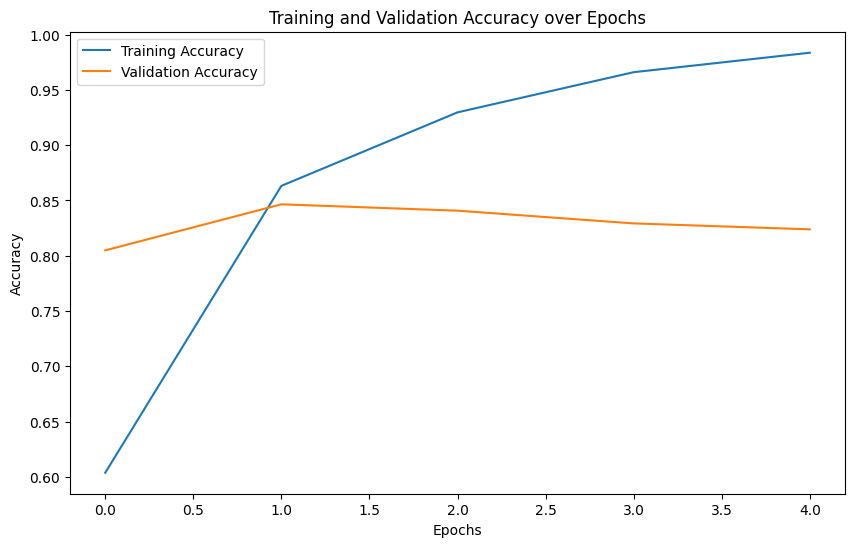

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
perdida, exactitud = modelo.evaluate([X_test_sequences, X_test_new_features], y_test,
                                     batch_size=32, verbose=2)
print('Pérdida de la Prueba:', perdida)
print('Exactitud de la Prueba (Test accuracy):', exactitud)


313/313 - 6s - loss: 0.3455 - accuracy: 0.8483 - 6s/epoch - 19ms/step
Pérdida de la Prueba: 0.3455069363117218
Exactitud de la Prueba (Test accuracy): 0.8482999801635742
